# MODELLING

## Loading the data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
# sns.set()

In [88]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve, \
precision_recall_curve, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, accuracy_score
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
import category_encoders as ce
from sklearn.compose import ColumnTransformer
import pickle

In [3]:
%%time
filename = "df_comp_pluto_merged.csv"
df = pd.read_csv(filename,index_col=False)
df = df[df.Borough_x == 'BRONX']
df['Heat'] = np.where(df['Complaint Type'] == 'HEAT/HOT WATER', 1, 0)
# df = 

Wall time: 5.05 s


In [4]:
def check_values(df):
    col_desc = []
    data = {
        'features': [col for col in df.columns],
        'data_type': [df[col].dtype for col in df.columns],
        'nan_total': [df[col].isna().sum() for col in df.columns],
        'nan_pct': [round(df[col].isna().sum()/len(df)*100,2) for col in df.columns],
        'unique': [df[col].nunique() for col in df.columns],
        'values_ex': [df[col].drop_duplicates().sample(df[col].nunique()).values if df[col].nunique() <= 5 else df[col].drop_duplicates().sample(2).values for col in df.columns]
    }
    return pd.DataFrame(data)

In [5]:
check_values(df)

,features,data_type,nan_total,nan_pct,unique,values_ex
0,Unnamed: 0,int64,0,0.0,58493,"[19852, 175924]"
1,Unique Key,float64,0,0.0,58462,"[35830836.0, 36806346.0]"
2,Created Date,object,0,0.0,53956,"[2016-01-11 09:32:47, 2015-09-14 11:07:00]"
3,Complaint Type,object,0,0.0,13,"[ELECTRIC, WATER LEAK]"
4,Incident Zip,float64,0,0.0,25,"[10472.0, 10467.0]"
5,Incident Address,object,0,0.0,8844,"[286 HOLLYWOOD AVENUE, 751 BECK STREET]"
6,Street Name,object,0,0.0,879,"[BONNER PLACE, EAST 176 STREET]"
7,City,object,0,0.0,1,[BRONX]
8,Status,object,0,0.0,3,"[Open, Closed, In Progress]"
9,Borough_x,object,0,0.0,1,[BRONX]


In [6]:
df.columns

Index(['Unnamed: 0', 'Unique Key', 'Created Date', 'Complaint Type',
       'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Status',
       'Borough_x', 'Latitude', 'Longitude', 'hour', 'month', 'year',
       'Borough_y', 'ZipCode', 'Address', 'LandUse', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'NumBldgs', 'NumFloors',
       'UnitsTotal', 'BldgFront', 'BldgDepth', 'LotType', 'BsmtCode',
       'AssessTot', 'YearBuilt', 'YearAlter1', 'AlterAge',
       'HEAT/HOT WATER_count', 'UNSANITARY CONDITION_count',
       'PAINT/PLASTER_count', 'PLUMBING_count', 'DOOR/WINDOW_count',
       'WATER LEAK_count', 'ELECTRIC_count', 'GENERAL_count',
       'FLOORING/STAIRS_count', 'APPLIANCE_count', 'Heat'],
      dtype='object')

### Drop unneeded columns for modelling

In [7]:
df_train = df.drop(columns=['Unnamed: 0', 'Unique Key', 'Created Date', 'Complaint Type',
       'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Status',
       'Borough_x', 'Latitude', 'Longitude','ZipCode', 'Borough_y', 'Address', 'YearBuilt', 'YearAlter1', 'BldgFront', 'BldgDepth',
        'HEAT/HOT WATER_count', 'UNSANITARY CONDITION_count',
       'PAINT/PLASTER_count', 'PLUMBING_count', 'DOOR/WINDOW_count',
       'WATER LEAK_count', 'ELECTRIC_count', 'GENERAL_count',
       'FLOORING/STAIRS_count', 'APPLIANCE_count'])
df_train.shape

(58493, 22)

In [8]:
df_train.dtypes

hour          float64
month         float64
year          float64
LandUse       float64
LotArea         int64
BldgArea        int64
ComArea         int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
GarageArea      int64
StrgeArea       int64
FactryArea      int64
OtherArea       int64
NumBldgs        int64
NumFloors     float64
UnitsTotal      int64
LotType       float64
BsmtCode      float64
AssessTot       int64
AlterAge      float64
Heat            int32
dtype: object

## Checking Categorical Features

### LandUse

LandUse column is already encoded according to the following:

| CODES | DECODES |
|--- | --- |
| 1 | One & Two Family Buildings |
| 2 | Multi-Family Walk-Up Buildings |
| 3 | Multi-Family Elevator Buildings |
| 4 | Mixed Residential & Commercial Buildings |
| 5 | Commercial & Office Buildings |
| 6 | Industrial & Manufacturing |
| 7 | Transportation & Utility |
| 8 | Public Facilities & Institutions |
| 9 | Open Space & Outdoor Recreation |
| 10 | Parking Facilities |
| 11 | Vacant Land |

The bar chart below shows no difference in LandUse distribution for heat and non-heat complaints, thus this column will not be used

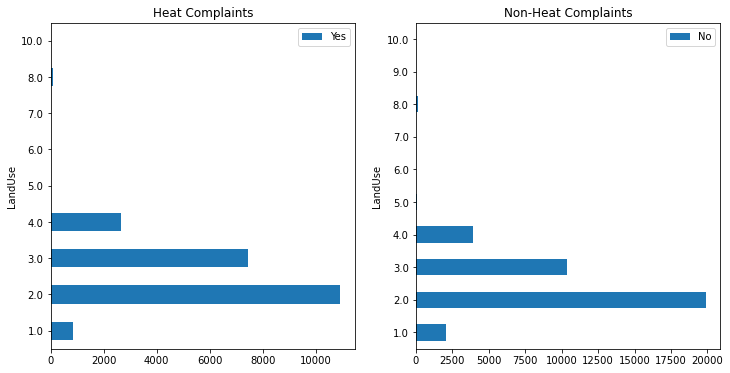

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df[df.Heat ==1].groupby('LandUse')['Heat'].count().plot.barh(ax=ax[0], label='Yes')
ax[0].set_title('Heat Complaints')
ax[0].legend()
df[df.Heat ==0].groupby('LandUse')['Heat'].count().plot.barh(ax=ax[1], label='No')
ax[1].set_title('Non-Heat Complaints')
ax[1].legend()
plt.show()

### LotType

LotType column is already encoded according to the following:
    
| Codes | Decodes |
| ---|---|
| 0 | Mixed or Unknown |
| 1 | Block assemblage |
| 2 | Waterfront |
| 3 | Corner |
| 4 | Through |
| 5 | Inside |
| 6 | Interior lot |
| 7 | Island lot |
| 8 | Alley lot |
| 9 | Submerged land lot |

The bar chart below shows no difference in LotType distribution for heat and non-heat complaints, so this column will be removed

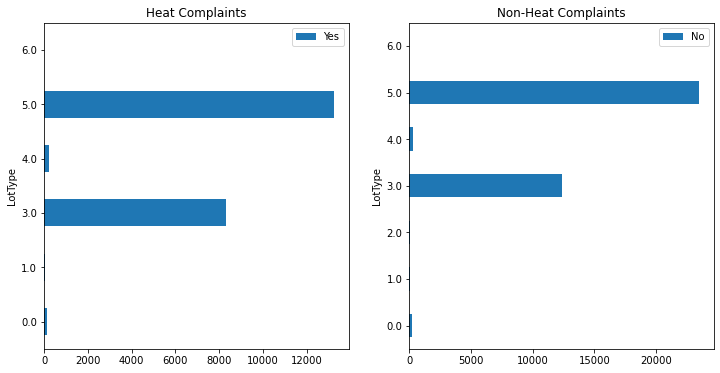

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df[df.Heat ==1].groupby('LotType')['Heat'].count().plot.barh(ax=ax[0], label='Yes')
ax[0].set_title('Heat Complaints')
ax[0].legend()
df[df.Heat ==0].groupby('LotType')['Heat'].count().plot.barh(ax=ax[1], label='No')
ax[1].set_title('Non-Heat Complaints')
ax[1].legend()
plt.show()

### BsmtCode

BsmtCode column is already encoded according to the following:

| Codes | Decodes |
| --- | --- |
| 0 | No basement |
| 1 | Full basement that is above grade |
| 2 | Full basement that is below grade |
| 3 | Partial basement that is above grade | 
| 4 | Partial basement that is below grade |
| 5 | Unknown |

The bar chart below shows no difference in BsmtCode distribution for heat and non-heat complaints, so this column will be removed

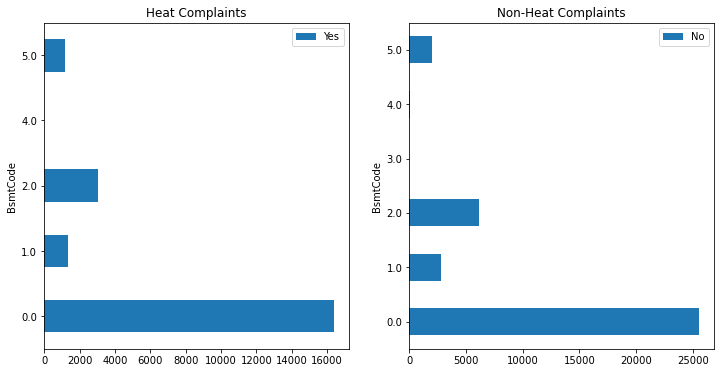

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df[df.Heat ==1].groupby('BsmtCode')['Heat'].count().plot.barh(ax=ax[0], label='Yes')
ax[0].set_title('Heat Complaints')
ax[0].legend()
df[df.Heat ==0].groupby('BsmtCode')['Heat'].count().plot.barh(ax=ax[1], label='No')
ax[1].set_title('Non-Heat Complaints')
ax[1].legend()
plt.show()

In [12]:
df_train.columns

Index(['hour', 'month', 'year', 'LandUse', 'LotArea', 'BldgArea', 'ComArea',
       'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea',
       'FactryArea', 'OtherArea', 'NumBldgs', 'NumFloors', 'UnitsTotal',
       'LotType', 'BsmtCode', 'AssessTot', 'AlterAge', 'Heat'],
      dtype='object')

## Remove outliers

In [13]:
clip_cols = ['LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'NumBldgs', 'NumFloors', 'UnitsTotal', 'AssessTot', 'AlterAge']
df_clipped = df_train[clip_cols].quantile([0.05, 0.95])
df_clipped

,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,NumBldgs,NumFloors,UnitsTotal,AssessTot,AlterAge
0.05,2200.0,2565.0,0.0,2166.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,24800.8,0.0
0.95,34238.0,136913.0,6250.0,127662.0,0.0,4797.0,0.0,0.0,0.0,0.0,2.0,8.0,123.0,3179250.0,79.0


In [14]:
np.sum([df_train.OfficeArea > 0])

2545

### drop columns
drop columns that have the same value for 5% and 95% percentile as they do not provide information

In [15]:
dropped_cols = ['OfficeArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea']
clip_cols = ['LotArea', 'BldgArea', 'ComArea', 'ResArea', 'RetailArea', 'NumBldgs', 'NumFloors', 'UnitsTotal', 'AssessTot', 'AlterAge']
df_clipped = df_train[clip_cols].quantile([0.05, 0.95])
df_clipped

,LotArea,BldgArea,ComArea,ResArea,RetailArea,NumBldgs,NumFloors,UnitsTotal,AssessTot,AlterAge
0.05,2200.0,2565.0,0.0,2166.0,0.0,1.0,2.0,2.0,24800.8,0.0
0.95,34238.0,136913.0,6250.0,127662.0,4797.0,2.0,8.0,123.0,3179250.0,79.0


### Filter values based on the computed percentiles

In [16]:
df_train_clipped = df_train[clip_cols].apply(lambda x: x[(x>df_clipped.loc[0.05,x.name]) & 
                                    (x < df_clipped.loc[0.95,x.name])], axis=0)
df_train_clipped

,LotArea,BldgArea,ComArea,ResArea,RetailArea,NumBldgs,NumFloors,UnitsTotal,AssessTot,AlterAge
34,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
35,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
36,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
54,6000.0,27000.0,NaN,27000.0,NaN,NaN,5.0,31.0,834300.0,NaN
55,6000.0,27000.0,NaN,27000.0,NaN,NaN,5.0,31.0,834300.0,NaN
...,...,...,...,...,...,...,...,...,...,...
180366,2542.0,9250.0,1200.0,8050.0,1200.0,NaN,5.0,10.0,72400.0,NaN
180367,8000.0,28165.0,1043.0,27122.0,NaN,NaN,5.0,43.0,418500.0,NaN
180370,20505.0,116897.0,NaN,116897.0,NaN,NaN,NaN,NaN,1889663.0,NaN
180372,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_train_fin = pd.concat([df_train.drop(columns=clip_cols), df_train_clipped], axis=1)
df_train_fin

,hour,month,year,LandUse,OfficeArea,GarageArea,StrgeArea,FactryArea,OtherArea,LotType,...,LotArea,BldgArea,ComArea,ResArea,RetailArea,NumBldgs,NumFloors,UnitsTotal,AssessTot,AlterAge
34,18.0,12.0,2019.0,2.0,0,0,0,0,0,5.0,...,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
35,18.0,4.0,2019.0,2.0,0,0,0,0,0,5.0,...,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
36,5.0,6.0,2019.0,2.0,0,0,0,0,0,5.0,...,7889.0,23425.0,NaN,23425.0,NaN,NaN,5.0,32.0,615150.0,NaN
54,17.0,12.0,2019.0,2.0,0,0,0,0,0,5.0,...,6000.0,27000.0,NaN,27000.0,NaN,NaN,5.0,31.0,834300.0,NaN
55,16.0,8.0,2019.0,2.0,0,0,0,0,0,5.0,...,6000.0,27000.0,NaN,27000.0,NaN,NaN,5.0,31.0,834300.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180366,12.0,10.0,2019.0,2.0,0,0,0,0,0,5.0,...,2542.0,9250.0,1200.0,8050.0,1200.0,NaN,5.0,10.0,72400.0,NaN
180367,16.0,10.0,2019.0,2.0,1043,0,0,0,0,5.0,...,8000.0,28165.0,1043.0,27122.0,NaN,NaN,5.0,43.0,418500.0,NaN
180370,2.0,10.0,2019.0,3.0,0,0,0,0,0,4.0,...,20505.0,116897.0,NaN,116897.0,NaN,NaN,NaN,NaN,1889663.0,NaN
180372,19.0,10.0,2019.0,1.0,0,0,0,0,0,5.0,...,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_train_fin.isna().sum()/len(df_train_fin)*100

hour            0.000000
month           0.000000
year            0.000000
LandUse         0.000000
OfficeArea      0.000000
GarageArea      0.000000
StrgeArea       0.000000
FactryArea      0.000000
OtherArea       0.000000
LotType         0.000000
BsmtCode        0.000000
Heat            0.000000
LotArea        10.008035
BldgArea       10.018293
ComArea        79.753133
ResArea        10.047356
RetailArea     85.705982
NumBldgs      100.000000
NumFloors      13.037457
UnitsTotal     10.440566
AssessTot      10.025131
AlterAge       80.592550
dtype: float64

### Drop columns with high unknown values

In [19]:
df_train_fin.drop(columns=['NumBldgs', 'ComArea', 'RetailArea', 'AlterAge', 'year', 'FactryArea'], inplace=True)
df_train_fin.dropna(inplace=True)
df_train_fin.shape

(45544, 16)

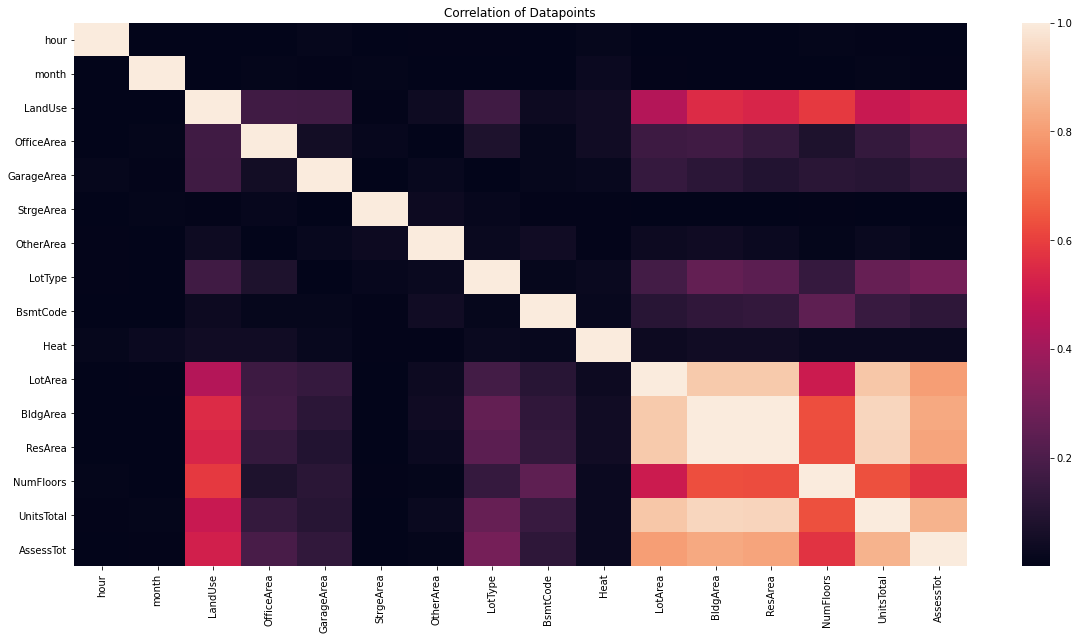

In [20]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train_fin.corr().abs(),annot=False)
plt.title('Correlation of Datapoints')
plt.show()

## Bin hour column

make a new feature, hourbin, to categorize the hour into 'early morning', 'morning', 'afternoon', and 'evening'.

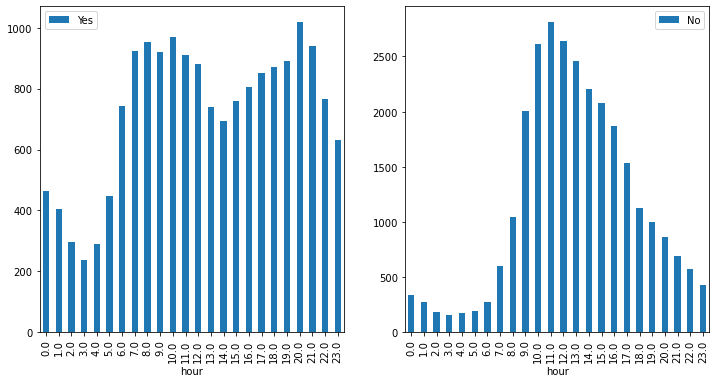

Wall time: 2.97 s


In [22]:
%%time
fig, ax = plt.subplots(1,2, figsize=(12,6))
df_train_fin[df_train_fin.Heat == 1].groupby('hour')['hour'].count().plot.bar(label='Yes', ax=ax[0])
ax[0].legend()
df_train_fin[df_train_fin.Heat == 0].groupby('hour')['hour'].count().plot.bar(label='No', ax=ax[1])
ax[1].legend()
plt.show()

In [23]:
def hour_binning(value):
    if value < 6:
        result = 'early morning'
    elif value < 11:
        result = 'morning'
    elif value < 16:
        result = 'afternoon'
    else: result = 'evening'
    return result

df_train_fin['hourbin'] = df_train_fin['hour'].apply(hour_binning)
df_train_fin[['hour','hourbin']]

,hour,hourbin
34,18.0,evening
35,18.0,evening
36,5.0,early morning
54,17.0,evening
55,16.0,evening
...,...,...
180285,7.0,morning
180333,12.0,afternoon
180366,12.0,afternoon
180367,16.0,evening


In [24]:
df_train_fin['bldgperlot'] = df_train_fin['BldgArea'] / df_train_fin['LotArea']
df_train_fin['bldgperlot'].head()

34    2.969324
35    2.969324
36    2.969324
54    4.500000
55    4.500000
Name: bldgperlot, dtype: float64

# modelling

## Preparing train and test set

In [25]:
df_train_fin.columns

Index(['hour', 'month', 'LandUse', 'OfficeArea', 'GarageArea', 'StrgeArea',
       'OtherArea', 'LotType', 'BsmtCode', 'Heat', 'LotArea', 'BldgArea',
       'ResArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'hourbin',
       'bldgperlot'],
      dtype='object')

In [26]:
X = df_train_fin.drop(columns=['Heat', 'hour', 'LotArea', 'BsmtCode', 'LotType', 'LandUse'])
y = df_train_fin['Heat']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, stratify=y, test_size=0.33, random_state=26)
transformer = ColumnTransformer([
            ('onehot', OneHotEncoder(drop='first'), ['hourbin'])
#             ('poly', PolynomialFeatures(degree=2), ['OfficeArea','GarageArea','StrgeArea','OtherArea','BldgArea','NumFloors','UnitsTotal'])
        ], remainder='passthrough', n_jobs=4, verbose=1)
X_train_val_prep = transformer.fit_transform(X_train_val)
X_test_prep = transformer.transform(X_test)

In [27]:
X.columns

Index(['month', 'OfficeArea', 'GarageArea', 'StrgeArea', 'OtherArea',
       'BldgArea', 'ResArea', 'NumFloors', 'UnitsTotal', 'AssessTot',
       'hourbin', 'bldgperlot'],
      dtype='object')

## Baseline model

### Majority classifier

always predict the majority class, in this case 0 or "No" (not heat complaint), for the target value. 

In [28]:
df_train_fin.Heat.value_counts()

0    28136
1    17408
Name: Heat, dtype: int64

In [29]:
print(classification_report(y_test, np.zeros(y_test.shape)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      9285
           1       0.00      0.00      0.00      5745

    accuracy                           0.62     15030
   macro avg       0.31      0.50      0.38     15030
weighted avg       0.38      0.62      0.47     15030



C:\Users\azuka\anaconda3-1\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Single-feature predictive modelling

in this classification problem, the class is predicted by only one variable. we will make a decision tree with only one decision level with the most-informative feature (decision stump).

In [30]:
dtc_baseline = DecisionTreeClassifier(max_depth=1)
dtc_baseline.fit(X_train_val_prep, y_train_val)
print(classification_report(y_test, dtc_baseline.predict(X_test_prep)))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      9285
           1       0.55      0.34      0.42      5745

    accuracy                           0.64     15030
   macro avg       0.61      0.59      0.58     15030
weighted avg       0.62      0.64      0.62     15030



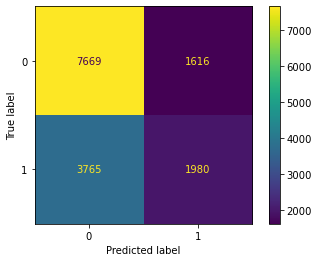

In [31]:
plot_confusion_matrix(dtc_baseline, X_test_prep, y_test)
plt.show()

In [32]:
feature_names = list(transformer.transformers_[0][1].get_feature_names())
# feature_names.extend(list(transformer.transformers_[1][1].get_feature_names()))
old_col = list(X_train_val.drop(columns=['hourbin']))#,'OfficeArea','GarageArea','StrgeArea','OtherArea','BldgArea','NumFloors','UnitsTotal']).columns)
feature_names.extend(old_col)

feature_names

['x0_early morning',
 'x0_evening',
 'x0_morning',
 'month',
 'OfficeArea',
 'GarageArea',
 'StrgeArea',
 'OtherArea',
 'BldgArea',
 'ResArea',
 'NumFloors',
 'UnitsTotal',
 'AssessTot',
 'bldgperlot']

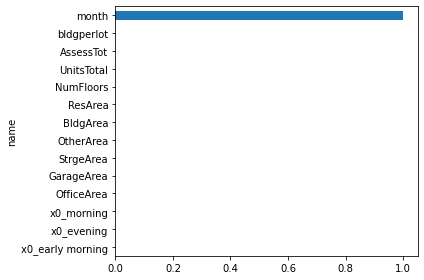

In [33]:
df_feature = pd.DataFrame({'name': feature_names, 'tree':dtc_baseline.feature_importances_})
df_feature.set_index('name').sort_values('tree')['tree'].plot.barh()
plt.tight_layout()
plt.show()

according to this model, 'month' column is the most important feature to differentiate between heat and non-heat complaints. based on the decision tree plot below, a decision stump with month <= 10.5 separates the sample into two leaves with high impurity as shown by the high gini ratio (0.439 and 0.492) 

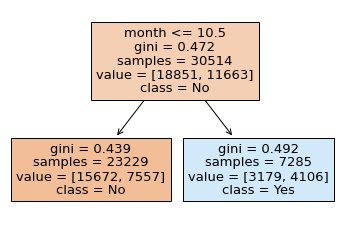

In [34]:
plot_tree(dtc_baseline, feature_names=feature_names, class_names=['No', 'Yes'], filled=True)
plt.show()

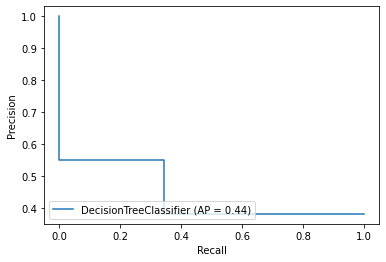

In [35]:
plot_precision_recall_curve(dtc_baseline, X_test_prep, y_test)
plt.show()

## Benchmark modelling

### Make pipelines with different steps

the models used are:
1. Logistic Regression
1. Decision Tree Classifier
1. Stochastic Gradient Descent
1. Naive Bayes

the strategy used for these pipelines are:
1. Oversampling with SMOTE
1. Scaling with MinMaxScaler
1. Feature selection with RFE
1. Oversampling with RandomOverSampler
1. Combined oversampling (SMOTE) and undersampling (TomekLinks) with SMOTETomek
1. Combined oversampling (SMOTE) and undersampling (ENN (Edited Nearest Neighbours))with SMOTEENN

In [36]:
def pipe_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
#         ('scaler', MinMaxScaler()),
#         ('sampling', SMOTE()),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [37]:
def pipe_smote_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
#         ('scaler', MinMaxScaler()),
        ('sampling', SMOTE()),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [38]:
def pipe_scale_smote_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
        ('scaler', MinMaxScaler()),
        ('sampling', SMOTE()),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [39]:
def pipe_scale_rfe_smote_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
        ('scaler', MinMaxScaler()),
        ('rfe', RFE(model[1])),
        ('sampling', SMOTE()),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [40]:
def pipe_scale_overs_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
        ('scaler', MinMaxScaler()),
#         ('rfe', RFE(model[1])),
        ('sampling', RandomOverSampler(sampling_strategy='minority')),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [41]:
def pipe_scale_overs_unders_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
        ('scaler', MinMaxScaler()),
#         ('rfe', RFE(model[1])),
#         ('sampling', RandomOverSampler(sampling_strategy=0.1)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=0.5)),
        ('sampling', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

In [42]:
def pipe_scale_overs_unders_enn_model(models):
    pipelines = []
    for model in models:
        pl = Pipeline([
        # ('transfr', transformer),
        ('scaler', MinMaxScaler()),
#         ('rfe', RFE(model[1])),
#         ('sampling', RandomOverSampler(sampling_strategy=0.1)),
#         ('sampling2', RandomUnderSampler(sampling_strategy=0.5)),
        ('sampling', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
        ('model', model[1])
])
        pipelines.append(pl)
    return pipelines

### Make a function for cross validation

use cross_validate to return several metrics at once

In [43]:
def model_evaluation(pipes, metric):
    skfold = StratifiedKFold(n_splits=5, random_state=26, shuffle=True)
    model_cvs = []
    for pipe in pipes:
        model_cv = cross_validate(pipe, X_train_val_prep, y_train_val, cv=skfold, scoring=metric, return_train_score=True, n_jobs=4, verbose=1)
        model_cvs.append(model_cv)
    return model_cvs

### Make a function to summarize the cross validation results

In [44]:
def results_dataframe(models, model_cvs, metric):
    scores = np.zeros((len(models),len(metric)*2))
    j = 0
    for model, model_cv in zip(models, model_cvs):
        
        model_score = []
        for i in model_cv:
            
            if i == 'fit_time' or i == 'score_time':
                continue
            model_score.append(model_cv[i].mean())
        scores[j] = model_score
        j+=1
    return pd.DataFrame(scores, index=[i[0] for i in models], columns = [i for i in list(model_cv_1[0].keys()) if i not in ('fit_time', 'score_time')])
    # return scores

### Cross validate

try several strategies and cross validate the model. use the f1 score for test set to compare the models on our cross validation set (X_train_val, y_train_val).

1. Step: Model only

only DecisionTreeClassifier gives good performance while the others are severely underfitted. LogisticRegression and NaiveBayes perform only slightly better than random classifier, as shown by the AUC score of 0.500 and 0.525.

despite having the best performance the DecisionTreeClassifier is overfitted since it scores very high (all metrics above 0.95) but only on the training set. 

In [45]:
models_1 = [('logreg', LogisticRegression()),('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_1 = pipe_model(models_1)
model_cv_1 = model_evaluation(pl_1, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


In [46]:
df_model = results_dataframe(models_1, model_cv_1, metric).T
df_model

,logreg,tree,sgdc,nb
test_f1,0.039886,0.584766,0.014488,0.106937
train_f1,0.040612,0.938086,0.014779,0.109280
test_accuracy,0.618339,0.691126,0.616897,0.616143
train_accuracy,0.618380,0.954349,0.616594,0.616619
test_roc_auc,0.500985,0.680079,0.494183,0.524953
train_roc_auc,0.501346,0.995240,0.495593,0.525232
test_recall,0.020750,0.569066,0.007458,0.060191
train_recall,0.021135,0.904827,0.007653,0.061562
test_precision,0.520992,0.601541,0.310954,0.481785
train_precision,0.519775,0.973884,0.293389,0.488004


2. Steps: Oversampling with SMOTE, model

adding SMOTE for oversampling step improves LogisticRegression and SGBC greatly

In [47]:
models_2 = [('logreg', LogisticRegression(solver='saga')),('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_2 = pipe_smote_model(models_2)
model_cv_2 = model_evaluation(pl_2, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   15.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   14.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


In [48]:
df_smote_model =  results_dataframe(models_2, model_cv_2, metric).T
df_smote_model

,logreg,tree,sgdc,nb
test_f1,0.523544,0.584995,0.341721,0.169936
train_f1,0.523922,0.938183,0.341915,0.171221
test_accuracy,0.439601,0.687586,0.475910,0.612244
train_accuracy,0.440077,0.954308,0.476053,0.612440
test_roc_auc,0.525677,0.677313,0.507328,0.524639
train_roc_auc,0.526070,0.995215,0.510244,0.524941
test_recall,0.805967,0.576095,0.605144,0.104263
train_recall,0.806246,0.907164,0.605252,0.105118
test_precision,0.387770,0.594288,0.387206,0.467664
train_precision,0.388124,0.971401,0.396008,0.468799


3. Steps: Scaling, oversampling with SMOTE, model

Scaling greatly improves LogisticRegression, StochasticGradientDescent and NaiveBayes, although Decision TreeClassifier still has the best performance of all.

In [49]:
models_3 = [('logreg', LogisticRegression(solver='saga')), ('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_3 = pipe_scale_smote_model(models_3)
model_cv_3 = model_evaluation(pl_3, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished


In [50]:
df_scale_smote_model = results_dataframe(models_3, model_cv_3, metric).T
df_scale_smote_model

,logreg,tree,sgdc,nb
test_f1,0.564673,0.594728,0.573348,0.294979
train_f1,0.565084,0.938178,0.573360,0.295667
test_accuracy,0.569869,0.688733,0.561742,0.634037
train_accuracy,0.570017,0.954308,0.561742,0.634356
test_roc_auc,0.637795,0.683037,0.621109,0.657231
train_roc_auc,0.639112,0.995213,0.622957,0.658062
test_recall,0.730002,0.597532,0.770470,0.200895
train_recall,0.730922,0.907078,0.770471,0.201084
test_precision,0.460457,0.592015,0.456555,0.558435
train_precision,0.460653,0.971488,0.456559,0.561052


4. Steps: Scaling, feature selection with RFE, oversampling with SMOTE, model
    
Feature selection with RFE was done only on LogisticRegression and DecisionTreeClassifier. no improvement compared with only scale+SMOTE+model.

In [51]:
models_4 = [('logreg', LogisticRegression(solver='saga', max_iter=500)), ('tree', DecisionTreeClassifier(random_state=26))]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_4 = pipe_scale_rfe_smote_model(models_4)
model_cv_4 = model_evaluation(pl_4, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.7s finished


In [52]:
df_rfe_smote_model = results_dataframe(models_4, model_cv_4, metric).T
df_rfe_smote_model

,logreg,tree
test_f1,0.541664,0.595357
train_f1,0.544537,0.886545
test_accuracy,0.579897,0.692862
train_accuracy,0.582094,0.916604
test_roc_auc,0.625900,0.693622
train_roc_auc,0.628379,0.982932
test_recall,0.658593,0.591271
train_recall,0.662519,0.852267
test_precision,0.466841,0.599677
train_precision,0.469240,0.923715


5. Steps: Scaling, oversampling with RandomOverSampler, model
    
Oversampling with RandomOverSampler doesn't have much difference with SMOTE for any of the models. DecisionTreeClassifier still has the highest performance.

In [53]:
models_5 = [('logreg', LogisticRegression(solver='saga')), ('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_5 = pipe_scale_overs_model(models_5)
model_cv_5 = model_evaluation(pl_5, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished


In [54]:
df_overs_model = results_dataframe(models_5, model_cv_5, metric).T
df_overs_model

,logreg,tree,sgdc,nb
test_f1,0.564686,0.596319,0.573348,0.287712
train_f1,0.564433,0.939279,0.573360,0.289829
test_accuracy,0.570951,0.691027,0.561742,0.633578
train_accuracy,0.570451,0.953464,0.561742,0.634193
test_roc_auc,0.637996,0.681793,0.628464,0.655340
train_roc_auc,0.639191,0.994993,0.630111,0.656341
test_recall,0.728200,0.596931,0.770470,0.193863
train_recall,0.728307,0.941675,0.770471,0.195361
test_precision,0.461191,0.595819,0.456555,0.559309
train_precision,0.460873,0.936899,0.456559,0.562071


6. Steps: Scaling, combined oversampling and undersampling with SMOTETomek, model

in this step, we use the combination of oversampling and undersampling with SMOTETomek. not much difference with only oversampling with RandomOverSampler or SMOTE.

In [55]:
models_6 = [('logreg', LogisticRegression(solver='saga')), ('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_6 = pipe_scale_overs_unders_model(models_6)
model_cv_6 = model_evaluation(pl_6, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.0min finished


In [56]:
df_overs_unders_model = results_dataframe(models_6, model_cv_6, metric).T
df_overs_unders_model

,logreg,tree,sgdc,nb
test_f1,0.569260,0.595363,0.573348,0.290003
train_f1,0.569521,0.915424,0.573360,0.291697
test_accuracy,0.564921,0.682342,0.561742,0.633939
train_accuracy,0.565019,0.935931,0.561742,0.634471
test_roc_auc,0.638128,0.678943,0.628043,0.662980
train_roc_auc,0.639277,0.978116,0.631961,0.663792
test_recall,0.752207,0.611421,0.770470,0.195835
train_recall,0.752808,0.907142,0.770471,0.196990
test_precision,0.457898,0.580146,0.456555,0.560071
train_precision,0.458013,0.923860,0.456559,0.562602


7. Steps: Combined oversampling and undersampling with SMOTEENN, model

SMOTEENN combined oversampling with SMOTE and undersampling with ENN (EditedNearestNeighbours). DecisionTreeClassifier performance increased with this method compared to SMOTETomek. NaiveBayes improved greatly while LogisticRegression only slightly.

DecisionTreeClassfier score reaches 0.638, which is the best of all steps and models we have tried. we will use this strategy for further model improvement

In [57]:
models_7 = [('logreg', LogisticRegression(solver='saga')), ('tree', DecisionTreeClassifier(random_state=26)), ('sgdc', SGDClassifier(random_state=26)), ('nb', GaussianNB())]
metric = ('f1', 'accuracy', 'roc_auc', 'recall', 'precision')
pl_7 = pipe_scale_overs_unders_enn_model(models_7)
model_cv_7 = model_evaluation(pl_7, metric)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.8min finished


In [58]:
df_overs_unders_enn_model = results_dataframe(models_7, model_cv_7, metric).T
df_overs_unders_enn_model

,logreg,tree,sgdc,nb
test_f1,0.577427,0.638258,0.573640,0.402365
train_f1,0.577575,0.744536,0.573680,0.406410
test_accuracy,0.520253,0.631055,0.561873,0.642427
train_accuracy,0.520376,0.740431,0.561865,0.645138
test_roc_auc,0.637309,0.674355,0.628893,0.695687
train_roc_auc,0.638428,0.790917,0.629604,0.696809
test_recall,0.857583,0.851582,0.771156,0.322484
train_recall,0.857841,0.989582,0.771264,0.325450
test_precision,0.435293,0.510407,0.456685,0.556472
train_precision,0.435372,0.596768,0.456686,0.563680


### Summary of cross validation for DecisionTreeClassifier

best strategy: combined oversampling and undersampling with SMOTEENN + model

test f1 score = 0.638

In [59]:
def summary_df(name):
    return pd.concat([df_model[[name]].rename(columns={name:'model'}),
           df_smote_model[[name]].rename(columns={name:'SMOTE+model'}),
           df_scale_smote_model[[name]].rename(columns={name:'Scaling+SMOTE+model'}),
           df_rfe_smote_model[[name]].rename(columns={name:'RFE+SMOTE+model'}),
           df_overs_model[[name]].rename(columns={name:'Scaling+RandOverSamp+model'}),
           df_overs_unders_model[[name]].rename(columns={name:'Scaling+SMOTETomek+model'}), 
          df_overs_unders_enn_model[[name]].rename(columns={name:'Scaling+SMOTEENN+model'})], axis=1)

In [60]:
summary_df_dtc = summary_df('tree')
summary_df_dtc

,model,SMOTE+model,Scaling+SMOTE+model,RFE+SMOTE+model,Scaling+RandOverSamp+model,Scaling+SMOTETomek+model,Scaling+SMOTEENN+model
test_f1,0.584766,0.584995,0.594728,0.595357,0.596319,0.595363,0.638258
train_f1,0.938086,0.938183,0.938178,0.886545,0.939279,0.915424,0.744536
test_accuracy,0.691126,0.687586,0.688733,0.692862,0.691027,0.682342,0.631055
train_accuracy,0.954349,0.954308,0.954308,0.916604,0.953464,0.935931,0.740431
test_roc_auc,0.680079,0.677313,0.683037,0.693622,0.681793,0.678943,0.674355
train_roc_auc,0.995240,0.995215,0.995213,0.982932,0.994993,0.978116,0.790917
test_recall,0.569066,0.576095,0.597532,0.591271,0.596931,0.611421,0.851582
train_recall,0.904827,0.907164,0.907078,0.852267,0.941675,0.907142,0.989582
test_precision,0.601541,0.594288,0.592015,0.599677,0.595819,0.580146,0.510407
train_precision,0.973884,0.971401,0.971488,0.923715,0.936899,0.923860,0.596768


In [61]:
summary_df_logreg = summary_df('logreg')
summary_df_logreg

,model,SMOTE+model,Scaling+SMOTE+model,RFE+SMOTE+model,Scaling+RandOverSamp+model,Scaling+SMOTETomek+model,Scaling+SMOTEENN+model
test_f1,0.039886,0.523544,0.564673,0.541664,0.564686,0.569260,0.577427
train_f1,0.040612,0.523922,0.565084,0.544537,0.564433,0.569521,0.577575
test_accuracy,0.618339,0.439601,0.569869,0.579897,0.570951,0.564921,0.520253
train_accuracy,0.618380,0.440077,0.570017,0.582094,0.570451,0.565019,0.520376
test_roc_auc,0.500985,0.525677,0.637795,0.625900,0.637996,0.638128,0.637309
train_roc_auc,0.501346,0.526070,0.639112,0.628379,0.639191,0.639277,0.638428
test_recall,0.020750,0.805967,0.730002,0.658593,0.728200,0.752207,0.857583
train_recall,0.021135,0.806246,0.730922,0.662519,0.728307,0.752808,0.857841
test_precision,0.520992,0.387770,0.460457,0.466841,0.461191,0.457898,0.435293
train_precision,0.519775,0.388124,0.460653,0.469240,0.460873,0.458013,0.435372


In [62]:
scores = summary_df_dtc.loc['test_f1'].T.to_frame()
scores

,test_f1
model,0.584766
SMOTE+model,0.584995
Scaling+SMOTE+model,0.594728
RFE+SMOTE+model,0.595357
Scaling+RandOverSamp+model,0.596319
Scaling+SMOTETomek+model,0.595363
Scaling+SMOTEENN+model,0.638258


## Model Improvement

strategies:
1. Boosting with AdaBoostClassifier
1. Bagging with RandomForestClassifier
1. Hyperparameter tuning for RandomForestClassifier

all the strategies are fitted with X_train_val, y_train_val and then evaluated on the test set (X_test, y_test)

In [63]:
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val_prep)
X_test_scaled = scaler.transform(X_test_prep)

### Evaluate the best DecisionTreeClassifier  on test set

the best model from previous section, which is DecisionTreeClassifier with scaling and SMOTEENN, is evaluated on test set. result: F1 score = 0.64

In [64]:
pl_7[1]

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sampling',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('model', DecisionTreeClassifier(random_state=26))])

In [65]:
dtc_smoteENN = pl_7[1]
dtc_smoteENN.fit(X_train_val_prep, y_train_val)
print('DTC with SMOTEENN')
print(classification_report(y_test, dtc_smoteENN.predict(X_test_prep)))

DTC with SMOTEENN
              precision    recall  f1-score   support

           0       0.84      0.50      0.63      9285
           1       0.51      0.85      0.64      5745

    accuracy                           0.63     15030
   macro avg       0.68      0.68      0.63     15030
weighted avg       0.72      0.63      0.63     15030



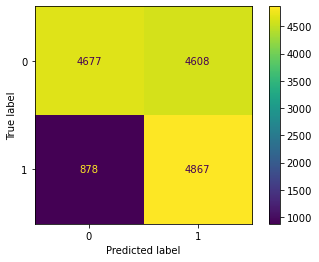

In [66]:
plot_confusion_matrix(dtc_smoteENN, X_test_prep, y_test)
plt.show()

In [67]:
def plot_learning_curve_scoring(estimator, title, X, y, axes=None, ylim=None, cv=None, scoring=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))
    _, axes = plt.subplots()

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

both the cross-validation score and the training score are increasing over increasing training examples, which suggests that it might be beneficial to add more training example. on the other hand, judging by the small f1 score increase over wide range (0 to ~25000 rows) of data, the score might increase but only very slightly.

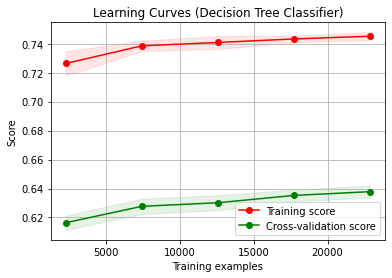

Wall time: 5min 24s


In [68]:
%%time
title = r"Learning Curves (Decision Tree Classifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
plot_learning_curve_scoring(dtc_smoteENN, title, X_train_val_prep, y_train_val, #axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, scoring='f1', n_jobs=4)
plt.show()

### 1. Boosting with AdaboostClassifier

no difference in performance between 50 estimators and 500 estimators, both give f1 score 0.65 on test set

In [69]:
%%time
# tree = DecisionTreeClassifier()
adaboost = AdaBoostClassifier(DecisionTreeClassifier(random_state=26), n_estimators=50, learning_rate=0.1, random_state=26)

X_train_val_samp, y_train_val_samp = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')).fit_resample(X_train_val_prep, y_train_val)
adaboost.fit(X_train_val_samp, y_train_val_samp)

Wall time: 1min 19s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=26),
                   learning_rate=0.1, random_state=26)

In [70]:
print('adaboost')
print(classification_report(y_test, adaboost.predict(X_test_prep)))

adaboost
              precision    recall  f1-score   support

           0       0.84      0.50      0.62      9285
           1       0.51      0.85      0.64      5745

    accuracy                           0.63     15030
   macro avg       0.68      0.67      0.63     15030
weighted avg       0.72      0.63      0.63     15030



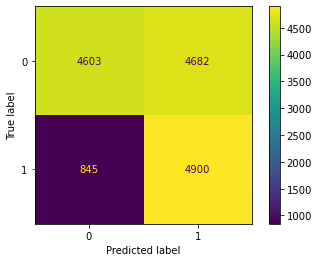

In [71]:
plot_confusion_matrix(adaboost, X_test_prep, y_test)
plt.show()

### 2. Bagging with RandomForestClassifier

when we use scaling, the model performs worse than without scaling, so we stick without scaling to build the ensemble. after bagging, f1 score increases to 0.68, which is the highest of all strategies we have tried. RandomForestClassifier will be used for hyperparameter tuning.

In [75]:
rfc_ = Pipeline([
        ('sampling', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
        ('tree', RandomForestClassifier(max_depth=20, random_state=26, oob_score=True, n_estimators=50, n_jobs=4, verbose=1))
])

rfc_.fit(X_train_val_prep, y_train_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.9s finished


Pipeline(steps=[('sampling',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('tree',
                 RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=4,
                                        oob_score=True, random_state=26,
                                        verbose=1))])

In [76]:
print('rfc')
print(classification_report(y_test, rfc_.predict(X_test_prep)))

rfc


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.88      0.54      0.67      9285
           1       0.54      0.87      0.67      5745

    accuracy                           0.67     15030
   macro avg       0.71      0.71      0.67     15030
weighted avg       0.75      0.67      0.67     15030



[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


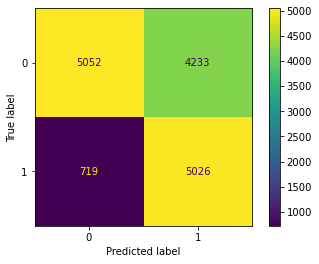

In [77]:
plot_confusion_matrix(rfc_, X_test_prep, y_test)
plt.show()

We will use our model prediction to ultimately count the total heat complaints in a certain area and then choose only the area with the highest number of complaints to focus on. Thus, we want to be as confident as possible when predicting whether a building will have a heat complaint or not --> increase threshold, for example, to 0.7 to increase the precision

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


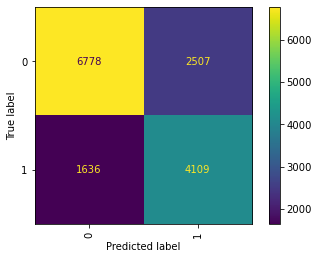

In [90]:
y_prob_rfc = rfc_.predict_proba(X_test_prep)
y_pred_rfc = np.where(y_prob_rfc[:,1]>0.7, 1, 0)
confusion_mat = confusion_matrix(y_test,y_pred_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1])
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='vertical')
plt.show()

In [124]:
print(f'precision: {precision_score(y_test,y_pred_rfc)}')
print(f'f1 score: {f1_score(y_test,y_pred_rfc)}')
print(f'accuracy: {accuracy_score(y_test,y_pred_rfc)}')

precision: 0.6210701330108828
f1 score: 0.6648329423185828
accuracy: 0.7243512974051897


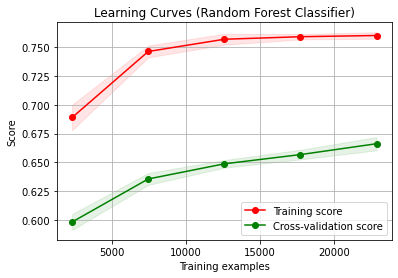

Wall time: 2min


In [78]:
%%time
title = r"Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
plot_learning_curve_scoring(rfc_, title, X_train_val_prep, y_train_val, #axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, scoring='f1', n_jobs=4)
# plt.savefig('learningcurve.png', bbox_inches = 'tight')
plt.show()

<Figure size 720x576 with 0 Axes>

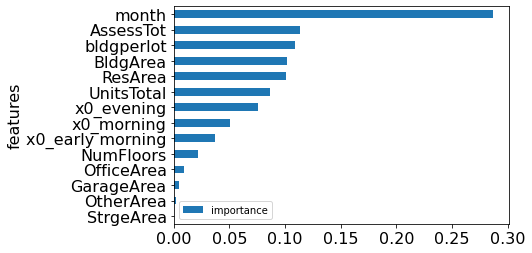

In [79]:
# rfc_[1].feature_importances_
plt.figure(figsize=(10,8))
feature_names = list(transformer.transformers_[0][1].get_feature_names())
feature_names.extend(list(X.drop(columns=['hourbin']).columns))
feat_imp = pd.DataFrame({'features':feature_names, 'importance':rfc_[1].feature_importances_}).set_index('features').sort_values('importance')
feat_imp.plot.barh()
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel('features', size=16)
# plt.savefig('featureimp.png', bbox_inches = 'tight')
plt.show()

In [80]:
rfc_final = Pipeline([
        ('transfr', ColumnTransformer([
            ('onehot', OneHotEncoder(drop='first'), ['hourbin'])
        ], remainder='passthrough', n_jobs=4, verbose=1)),
        ('sampling', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
        ('tree', RandomForestClassifier(max_depth=20, random_state=26, oob_score=True, n_estimators=50, n_jobs=4, verbose=1))
])

In [125]:
rfc_final.fit(X,y)
filename = 'rfc_final.sav'
pickle.dump(rfc_final, open(filename, 'wb'))
print('Finish')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.3s finished


Finish


### 3. Hyperparameter tuning for RandomForestClassifier

the hyperparameters used are number of estimators, maximum tree depth, maximum tree features, and decision criterion.

after an exhaustive process we get the supposedly best estimator and we evaluate the model on the test set. there is no difference in performance when compared with the previous RandomForestClassifier, both have f1 score of 0.68 on test set.

In [83]:
tree_params = {
    'tree__n_estimators': [50, 150],
    'tree__max_depth': [10,20,30],
    'tree__max_features': ['auto', 'sqrt', 'log2'],
    'tree__criterion': ['gini', 'entropy']
    }

pl_rfc = Pipeline([
        ('sampling', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
        ('tree', RandomForestClassifier(max_depth=20, random_state=26, oob_score=True, n_estimators=50, n_jobs=-1, verbose=1))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)
tree_grid = GridSearchCV(pl_rfc, param_grid=tree_params, scoring='f1', cv=skf, verbose=1, n_jobs=-1)
tree_grid.fit(X_train_val_prep, y_train_val)



tree_tuned = tree_grid.best_estimator_
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)
tree_tuned_score = cross_val_score(tree_tuned, X_train_val_prep, y_train_val, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
tree_tuned_score

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 17.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.0s finished


array([0.67212578, 0.66547754, 0.66452442, 0.66841846, 0.66688396])

In [84]:
tree_tuned = tree_grid.best_estimator_
tree_tuned.fit(X_train_val_prep, y_train_val)
print(classification_report(y_test, tree_tuned.predict(X_test_prep)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.88      0.55      0.68      9285
           1       0.55      0.88      0.67      5745

    accuracy                           0.67     15030
   macro avg       0.71      0.71      0.67     15030
weighted avg       0.75      0.67      0.67     15030



[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.5s finished


## Predict

suppose we want to predict whether some building on a particular location in Bronx will send a heat complaint in the evening on October. the database for the buildings is loaded only 200000 rows.

In [131]:
# %%time
# filename = 'comp_pluto_merged.csv'
# random.seed(26)
# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 20000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
# database = pd.read_csv(filename, skiprows=skip, index_col=False)
# # database = pd.read_csv(filename, index_col=False)
# database = database[database.Borough == 'BX']
# database.head()

In [132]:
database = df.sample(20000, random_state=26)

In [133]:
database['ZipCode'].nunique()

25

In [95]:
df.columns

Index(['Unnamed: 0', 'Unique Key', 'Created Date', 'Complaint Type',
       'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Status',
       'Borough_x', 'Latitude', 'Longitude', 'hour', 'month', 'year',
       'Borough_y', 'ZipCode', 'Address', 'LandUse', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'NumBldgs', 'NumFloors',
       'UnitsTotal', 'BldgFront', 'BldgDepth', 'LotType', 'BsmtCode',
       'AssessTot', 'YearBuilt', 'YearAlter1', 'AlterAge',
       'HEAT/HOT WATER_count', 'UNSANITARY CONDITION_count',
       'PAINT/PLASTER_count', 'PLUMBING_count', 'DOOR/WINDOW_count',
       'WATER LEAK_count', 'ELECTRIC_count', 'GENERAL_count',
       'FLOORING/STAIRS_count', 'APPLIANCE_count', 'Heat'],
      dtype='object')

In [134]:
database.columns

Index(['Unnamed: 0', 'Unique Key', 'Created Date', 'Complaint Type',
       'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Status',
       'Borough_x', 'Latitude', 'Longitude', 'hour', 'month', 'year',
       'Borough_y', 'ZipCode', 'Address', 'LandUse', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'NumBldgs', 'NumFloors',
       'UnitsTotal', 'BldgFront', 'BldgDepth', 'LotType', 'BsmtCode',
       'AssessTot', 'YearBuilt', 'YearAlter1', 'AlterAge',
       'HEAT/HOT WATER_count', 'UNSANITARY CONDITION_count',
       'PAINT/PLASTER_count', 'PLUMBING_count', 'DOOR/WINDOW_count',
       'WATER LEAK_count', 'ELECTRIC_count', 'GENERAL_count',
       'FLOORING/STAIRS_count', 'APPLIANCE_count', 'Heat'],
      dtype='object')

set the location we want to check. in this case, we set the zipcode

In [135]:
zipcode = database.sample(1, random_state=26)['ZipCode'].values[0]
zipcode

10452.0

in this NYC tax lot database we have loaded (only 200,000 data), there are 150 buildings in the area of zipcode 10465

In [136]:
zipcodedf = database[database.ZipCode == zipcode].drop_duplicates('Incident Address')
zipcodedf

,Unnamed: 0,Unique Key,Created Date,Complaint Type,Incident Zip,Incident Address,Street Name,City,Status,Borough_x,...,UNSANITARY CONDITION_count,PAINT/PLASTER_count,PLUMBING_count,DOOR/WINDOW_count,WATER LEAK_count,ELECTRIC_count,GENERAL_count,FLOORING/STAIRS_count,APPLIANCE_count,Heat
37523,38592,39015048.0,2018-04-23 12:39:22,PAINT/PLASTER,10452.0,941 JEROME AVENUE,JEROME AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,0
52497,53921,41468547.0,2019-01-16 11:50:56,HEAT/HOT WATER,10452.0,963 ANDERSON AVENUE,ANDERSON AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,1
57867,59348,38793805.0,2018-03-27 11:21:01,FLOORING/STAIRS,10452.0,976 ANDERSON AVENUE,ANDERSON AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,0
109844,113363,31988904.0,2015-11-13 15:45:44,HEAT/HOT WATER,10452.0,1265 NELSON AVENUE,NELSON AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,1
66096,67851,33608861.0,2016-06-15 11:00:12,PAINT/PLASTER,10452.0,1072 WOODYCREST AVENUE,WOODYCREST AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93029,95932,34922458.0,2016-12-02 08:57:36,HEAT/HOT WATER,10452.0,1149 NELSON AVENUE,NELSON AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,1
48195,49567,45017936.0,2019-11-25 12:19:59,UNSANITARY CONDITION,10452.0,1051 SUMMIT AVENUE,SUMMIT AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,0
132814,137064,41332685.0,2019-01-02 17:03:38,HEAT/HOT WATER,10452.0,167 WEST 161 STREET,WEST 161 STREET,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,1
167305,172822,42512402.0,2019-02-18 10:13:16,PAINT/PLASTER,10452.0,1047 SUMMIT AVENUE,SUMMIT AVENUE,BRONX,Closed,BRONX,...,692,537,476,310,322,192,198,213,128,0


In [137]:
X.drop(columns=['hourbin', 'month']).columns

Index(['OfficeArea', 'GarageArea', 'StrgeArea', 'OtherArea', 'BldgArea',
       'ResArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'bldgperlot'],
      dtype='object')

In [138]:
zipcodedf.loc[:,'bldgperlot'] = zipcodedf['BldgArea']/zipcodedf['LotArea']
zipcodedf_X = zipcodedf[list(X.drop(columns=['hourbin', 'month']).columns)]
zipcodedf_X.loc[:,'hourbin'] = 'evening'
zipcodedf_X.loc[:,'month'] = 1
zipcodedf_X.shape

C:\Users\azuka\anaconda3-1\envs\py38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\azuka\anaconda3-1\envs\py38\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(344, 12)

In [139]:
used_cols = X.columns
used_cols

Index(['month', 'OfficeArea', 'GarageArea', 'StrgeArea', 'OtherArea',
       'BldgArea', 'ResArea', 'NumFloors', 'UnitsTotal', 'AssessTot',
       'hourbin', 'bldgperlot'],
      dtype='object')

In [140]:
zipcodedf_X.columns

Index(['OfficeArea', 'GarageArea', 'StrgeArea', 'OtherArea', 'BldgArea',
       'ResArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'bldgperlot',
       'hourbin', 'month'],
      dtype='object')

In [141]:
filename = 'rfc_final.sav'
loaded_model = pickle.load((open(filename, 'rb')))

In [142]:
loaded_model

Pipeline(steps=[('transfr',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['hourbin'])],
                                   verbose=1)),
                ('sampling',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('tree',
                 RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=4,
                                        oob_score=True, random_state=26,
                                        verbose=1))])

In [143]:
zipcodedf_X.shape

(344, 12)

In [144]:
y_proba = loaded_model.predict_proba(zipcodedf_X[used_cols])
y_pred = np.where(y_proba[:,1]>0.7, 1, 0)
# y_pred = loaded_model.predict(zipcodedf_X[used_cols])
total_heat = y_pred.sum()
total_heat

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


269

According to our model, in the evening of a day in January in the area with zipcode 10452 there are 269 heat complaints from total 344 buildings

## Conclusion

we have built a predictive model that predicts the type of complaint sent to the NYC 311 Service Call based on several avalaible tax lot information. a baseline model was build with a decision tree classifier with a single decision level. this baseline model had f1 score of 0.44. we then built a benchmark model with a decision tree classifier which scored 0.58 then performed cross-validation with several strategies such as scaling, feature selection, and scaling. the best model was a decision tree classifier with combined oversampling and undersampling strategy. the model was improved by bagging with total estimators of 50 and maximum tree depth of 20. the final model scored 0.68 on the test set.

based on previous results, our model still suffers from overfitting since it scored high on train set but low on test set. our model only used 10 features from the total available building characteristic features of ~20-30. addition of traiing samples might improve the performance but only slightly. using different features combined with feature engineering might improve the model performance.